
Final statevector (only significant amplitudes):
|t=001000> |flag=0> |C=00000000>:  amplitude = 0.0625, probability = 0.0039, phase = 0.000 rad
|t=001010> |flag=0> |C=10000000>:  amplitude = 0.0625, probability = 0.0039, phase = -0.000 rad
|t=001001> |flag=0> |C=01000000>:  amplitude = 0.0625, probability = 0.0039, phase = -0.000 rad
|t=001100> |flag=0> |C=11000000>:  amplitude = 0.0625, probability = 0.0039, phase = -0.000 rad
|t=000100> |flag=0> |C=00100000>:  amplitude = 0.0625, probability = 0.0039, phase = 0.000 rad
|t=000110> |flag=1> |C=10100000>:  amplitude = 0.0625, probability = 0.0039, phase = -0.000 rad
|t=000101> |flag=1> |C=01100000>:  amplitude = 0.0625, probability = 0.0039, phase = -0.000 rad
|t=001000> |flag=0> |C=11100000>:  amplitude = 0.0625, probability = 0.0039, phase = 0.000 rad
|t=000110> |flag=0> |C=00010000>:  amplitude = 0.0625, probability = 0.0039, phase = 0.000 rad
|t=001000> |flag=1> |C=10010000>:  amplitude = 0.0625, probability = 0.0039, phase = -0.00

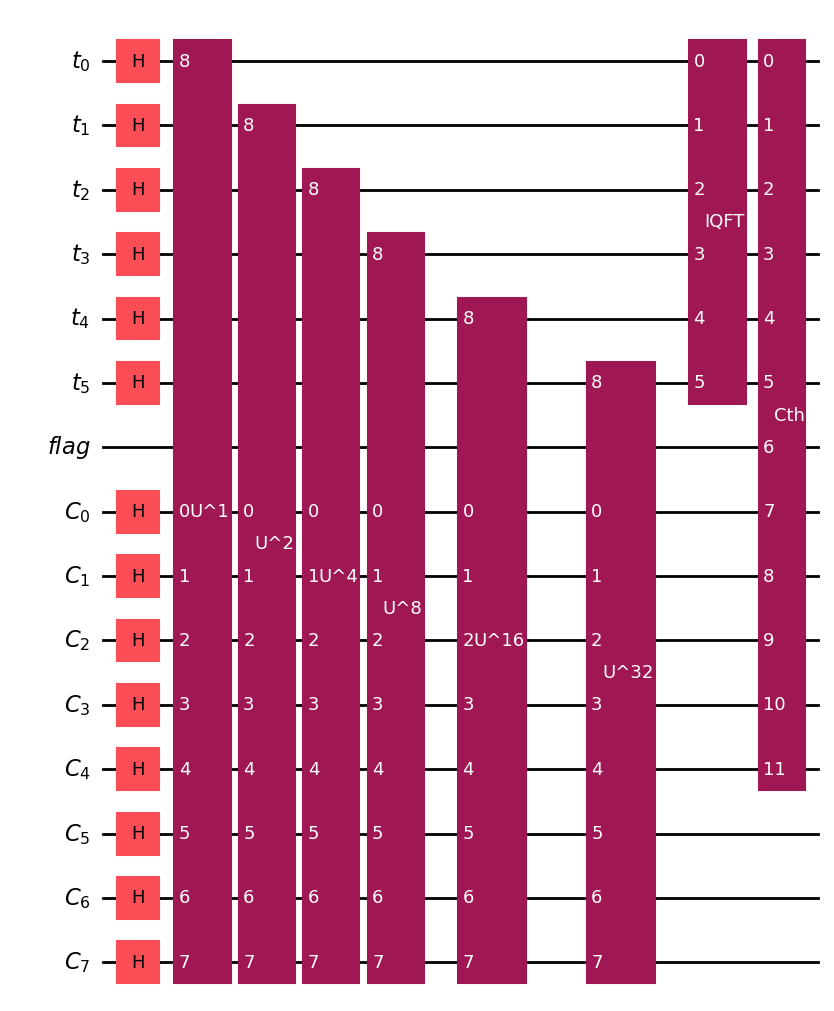

In [1]:
import warnings
warnings.filterwarnings("ignore")

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT, IntegerComparator
from qiskit.quantum_info import Statevector
from U_Power import build_U_power_oracle 
import numpy as np
from numpy import pi

# --- Parameters ---
t = 6  # number of precision qubits
threshold = 8  # threshold in phase units (0–63 since t=6)

theta_matrix = np.array([
    [0, pi/16, pi/32, pi/8],  # distances from city 0
    [pi/8, 0, pi/16, pi/32],  # distances from city 1
    [pi/16, pi/8, 0, pi/16],  # distances from city 2
    [pi/16, pi/32, pi/8, 0]   # distances from city 3
])

# --- Quantum Registers ---
precision = QuantumRegister(t, 't')        # Phase estimation qubits
cycle = QuantumRegister(8, 'C')            # Cycle qubits
flag = QuantumRegister(1, 'flag')          # Marking solutions which are under the threshold

circuit = QuantumCircuit(precision, flag, cycle)

# --- Step 1: Initialize t and C ---
circuit.h(precision)  # superposition for QPE

for i in range(8):
    circuit.h(cycle[i])  # superposition over tours

# --- Step 2: Controlled-U^(2^k) operations ---
for k in range(t):
    U_power = build_U_power_oracle(theta_matrix, 2 ** k)
    circuit.append(U_power, [*cycle, precision[k]])

# --- Step 3: Inverse QFT on precision register ---
circuit.append(QFT(t, inverse=True, do_swaps=True).to_gate(), precision)

# --- Step 4: Apply the comparator to mark valid solutions
Cth_gate = IntegerComparator(t, threshold, geq=False, name='Cth')
# circuit.append(Cth_gate, [*precision, flag[0], cycle[0], cycle[1]])
circuit.append(Cth_gate, [*precision, flag[0], cycle[0], cycle[1], cycle[2], cycle[3], cycle[4]])

# --- Step 5: Simulation ---
backend = Aer.get_backend('statevector_simulator')
compiled = transpile(circuit, backend)
result = backend.run(compiled).result()
state = result.get_statevector()

# --- Step 6: Display the result ---
num_t = len(precision)
num_flag = len(flag)
num_C = len(cycle)
total_qubits = num_t + num_C
total_qubits = num_t + num_C + num_flag

print("\nFinal statevector (only significant amplitudes):")
for i,amp in enumerate(state):
    if abs(amp) > 1e-6:
        bin_str = format(i, f'0{total_qubits}b')[::-1]  # reverse bits for display
        t_bits   = bin_str[:num_t]
        C_bits   = bin_str[num_t:total_qubits+1][::-1]
        phase = np.angle(amp)
        flag_bit = bin_str[num_t:num_t+num_flag]
        C_bits   = bin_str[num_t+num_flag:total_qubits+1]
        print(f"|t={t_bits}> |flag={flag_bit}> |C={C_bits}>:  amplitude = {abs(amp):.4f}, probability = {abs(amp)*abs(amp):.4f}, phase = {phase:.3f} rad")
        #print(f"amplitude = {abs(amp)*abs(amp):.4f}")

circuit.draw('mpl')

